In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [2]:
! pip install keras

mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# importing VGG16 from keras
from keras.applications import VGG16

#instantiating VGG convolutional base
conv_base = VGG16(weights = 'imagenet',
                 include_top = False ,
                 input_shape = (150,150,3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:

!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2018-10-21 20:24:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[=====================>]  65.43M   196MB/s   in 0.3s   

2018-10-21 20:24:54 (196 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
import zipfile
import os
from keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# define out directory and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

# data agumentation to avoid over fitting 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

# validation data should not be agumneted
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:

# adding densely connected layer on top of convbase of VGG16
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# adding dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:

# freezing the conv_base so that it prevents their weights to be updated
print ('this is the number of trainable weights before freezing the conv_base',len(model.trainable_weights))

this is the number of trainable weights before freezing the conv_base 30


In [10]:

# freezing
conv_base.trainable = False

In [11]:
print ('this is the number of trainable weights after freezing the conv_base',len(model.trainable_weights))

this is the number of trainable weights after freezing the conv_base 4


In [12]:

from keras import optimizers
# compiling the model
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 29s 294ms/step - loss: 0.6892 - acc: 0.5660 - val_loss: 0.5192 - val_acc: 0.7840
Epoch 2/100
100/100 [==============================] - 25s 255ms/step - loss: 0.5776 - acc: 0.7020 - val_loss: 0.4310 - val_acc: 0.8210
Epoch 3/100
100/100 [==============================] - 25s 254ms/step - loss: 0.5218 - acc: 0.7485 - val_loss: 0.3913 - val_acc: 0.8280
Epoch 4/100
100/100 [==============================] - 25s 255ms/step - loss: 0.4869 - acc: 0.7700 - val_loss: 0.3521 - val_acc: 0.8500
Epoch 5/100
100/100 [==============================] - 26s 255ms/step - loss: 0.4636 - acc: 0.7755 - val_loss: 0.3435 - val_acc: 0.8440
Epoch 6/100
100/100 [==============================] - 25s 255ms/step - loss: 0.4469 - acc: 0.8000 - val_loss: 0.3227 - val_acc: 0.8610
Epoch 7/100
100/100 [==============================] - 25s 255ms/step - loss: 0.4203 - acc: 0.8100 - val_loss: 0.3158 - val_acc: 0.8650
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 258ms/step - loss: 0.3215 - acc: 0.8585 - val_loss: 0.2555 - val_acc: 0.8840
Epoch 62/100
100/100 [==============================] - 26s 258ms/step - loss: 0.3217 - acc: 0.8600 - val_loss: 0.2572 - val_acc: 0.8890
Epoch 63/100
100/100 [==============================] - 26s 258ms/step - loss: 0.3293 - acc: 0.8655 - val_loss: 0.2621 - val_acc: 0.8870
Epoch 64/100
100/100 [==============================] - 26s 258ms/step - loss: 0.3171 - acc: 0.8600 - val_loss: 0.2554 - val_acc: 0.8870
Epoch 65/100
100/100 [==============================] - 26s 258ms/step - loss: 0.3374 - acc: 0.8505 - val_loss: 0.2569 - val_acc: 0.8910
Epoch 66/100
100/100 [==============================] - 26s 256ms/step - loss: 0.3203 - acc: 0.8630 - val_loss: 0.2586 - val_acc: 0.8910
Epoch 67/100
100/100 [==============================] - 26s 257ms/step - loss: 0.3190 - acc: 0.8555 - val_loss: 0.2533 - val_acc: 0.8840
Epoch 68/100
100/100 [===================

final val_acc after 10th epoch is 86.5% which is relatively better that un-pre-trainined model, but we can furthur improve accuracy by implementinf fine tuning- where we unfreeze the last conv layer of the pre trainined model and train the model along with the weights of the last layers.

 


In [13]:
# improving accuracy using fine tuning
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [14]:
# we will train last three convolutional layers "block5_conv1,2,3"
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

    
model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-5),
             metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 29s 293ms/step - loss: 0.3280 - acc: 0.8625 - val_loss: 0.2692 - val_acc: 0.8910
Epoch 2/100
100/100 [==============================] - 27s 266ms/step - loss: 0.2737 - acc: 0.8845 - val_loss: 0.2464 - val_acc: 0.9110
Epoch 3/100
100/100 [==============================] - 26s 264ms/step - loss: 0.2716 - acc: 0.8905 - val_loss: 0.2021 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 27s 266ms/step - loss: 0.2512 - acc: 0.8880 - val_loss: 0.2540 - val_acc: 0.9130
Epoch 5/100
100/100 [==============================] - 27s 266ms/step - loss: 0.2360 - acc: 0.9035 - val_loss: 0.2027 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 27s 265ms/step - loss: 0.2361 - acc: 0.9060 - val_loss: 0.2153 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 26s 264ms/step - loss: 0.2185 - acc: 0.9100 - val_loss: 0.2643 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 27s 265ms/step - loss: 0.0423 - acc: 0.9855 - val_loss: 0.3852 - val_acc: 0.9430
Epoch 62/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0543 - acc: 0.9810 - val_loss: 0.2546 - val_acc: 0.9540
Epoch 63/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0402 - acc: 0.9860 - val_loss: 0.3230 - val_acc: 0.9480
Epoch 64/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0535 - acc: 0.9810 - val_loss: 0.3593 - val_acc: 0.9440
Epoch 65/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0497 - acc: 0.9835 - val_loss: 0.3168 - val_acc: 0.9490
Epoch 66/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0436 - acc: 0.9865 - val_loss: 0.4537 - val_acc: 0.9260
Epoch 67/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0475 - acc: 0.9850 - val_loss: 0.3553 - val_acc: 0.9370
Epoch 68/100
100/100 [===================

In [15]:
print ('this is the number of trainable weights after freezing the conv_base',len(model.trainable_weights))

this is the number of trainable weights after freezing the conv_base 10


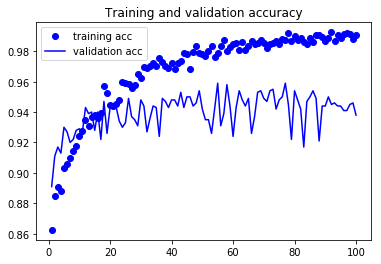

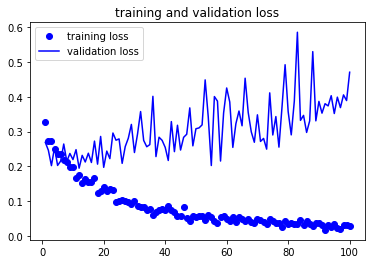

In [16]:
# plotting the results

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs , acc , 'bo',label = 'training acc')
plt.plot(epochs, val_acc,'b',label ='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs , loss , 'bo',label = 'training loss')
plt.plot(epochs , val_loss , 'b',label = 'validation loss')
plt.title ('training and validation loss')
plt.legend()

plt.show()